# Netflix Recommendation System

* Tutorial: https://news.towardsai.net/2uk
* Github: https://colab.research.google.com/drive/1QTVAzz-Uyv6kDH5RgmwE3dr508BzXms1?usp=sharing

**Data from Netflix**

*   combine_data_4.txt - This text file contains movie_id, customer_id, rating, date
*   List item - This CSV file contains movie_id and movie_title



 리눅스 명령어 !wget 으로 웹서버에 저장된 데이터를 가져온다. (gitHub, cloud 데이터도 가능) [참조링크](https://sevity.tistory.com/64)

In [1]:
# Download datasets
!wget https://zenodo.org/record/4556134/files/combined_data_4.txt?download=1
!wget https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/movie_titles.csv
!wget https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/new_features.csv

--2021-03-11 01:25:52--  https://zenodo.org/record/4556134/files/combined_data_4.txt?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 552537802 (527M) [text/plain]
Saving to: ‘combined_data_4.txt?download=1’

combined_data_4.txt 100%[===================>] 526.94M  13.4MB/s    in 45s     

2021-03-11 01:26:39 (11.8 MB/s) - ‘combined_data_4.txt?download=1’ saved [552537802/552537802]

--2021-03-11 01:26:39--  https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/movie_titles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577547 (564K) [text/plain]
Saving to: ‘movie_titles.csv’

mov

In [2]:
!pip install scikit-surprise # surprise를 활용해 구축한다. -- 타 라이브러리에 비해 Toy model을 구성할 때 쓰기 좋음!

     |████████████████████████████████| 11.8MB 267kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617580 sha256=eefe7fbd98b307ac3fb98b2c7fd0810f1cb28378b7c08ffb816ee6dc6defec70
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


Mount the data into google drive for files' persistence

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


**Import Important Packages**

In [4]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

# Load Data

*   combine_data_4.txt :- Read from this file. This is a comma separated file. It includes movie_id, customer_id, rating and date
*   netflix_rating.csv :- This is a csv file generated by reading from the combine_data_4.txt file





In [5]:
def load_data(): # csv 형태로 파일이 되어있다. json을 사용하면 어떻게?
    netflix_csv_file = open("netflix_rating.csv", mode = "w")
    rating_files = ["combined_data_4.txt?download=1"]  
    for file in rating_files:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(":"): # 여러 영화에 대한 고객별 평점 기록
                    movie_id = line.replace(":", "")
                else:
                    row_data = []
                    row_data = [item for item in line.split(",")]
                    row_data.insert(0, movie_id)
                    netflix_csv_file.write(",".join(row_data))  
                    netflix_csv_file.write('\n')
                    
    netflix_csv_file.close()
    df = pd.read_csv('netflix_rating.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])
    return df

**Display Netflix Rating Data**

In [6]:
netflix_rating_df = load_data()
netflix_rating_df
netflix_rating_df.head()
netflix_rating_df.groupby('movie_id').count() # 4000개의 영화에 대한 평점이 매겨져 있다.

,customer_id,rating,date
movie_id,,,
13368,527,527,527
13369,150,150,150
13370,2715,2715,2715
13371,112,112,112
13372,358,358,358
...,...,...,...
17766,605,605,605
17767,204,204,204
17768,1362,1362,1362


**Check for the duplicate records**

In [7]:
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum() # 완전히 똑같은 중복 데이터가 있는 지 확인 -- boolean series 형태로 반환

0

# Split Data into Train and Test Data

*   train_data = 80%
*   test_data = 20%


In [8]:
split_value = int(len(netflix_rating_df) * 0.80) # 80 : 20으로 데이터 셋을 나누기
train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

#Analysis of Data

Count of Ratings - 1, 2, 3, 4, 5

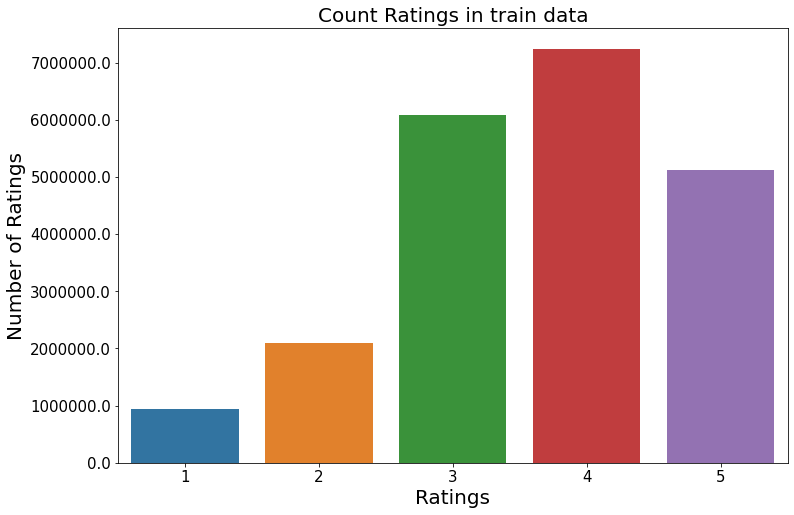

In [9]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

# Create User-Item Sparse Matrix

In User-Item sparse matrix, items' values are present in the column and users' values are present in the rows. The rating of the user is present in the cell.
> 일반 넘파이 행렬을 압축 희소 행렬로 바꾸는 과정 -- 메모리 낭비 보호.
[참조링크](https://rfriend.tistory.com/551)

In [10]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id))) # 고객 id(row), 영화 id(col)의 값을 인덱스로 가져와 압축 행렬을 만든다.
    return sparse_data

**Create Sparse Matrix from the Training Dataset**

In [11]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

**Create Sparse Matrix from the Test Dataset**

In [12]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

**Find Average Gloabal Rating of Movie**

In [13]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero() # 평점에 0이 없기 때문에 배열 사이즈로 나눈 값과 동일하다.
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.6291294662291467


**A Generic Method to Calculate Average Rating from Sparse Matrix**

In [14]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  #합을 구해서 n by 1 차원 매트릭스를 1차원으로 바꾼다.
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0} # user, movie 기준으로 스위칭해서 평균 평점을 구한다. -- 어렵다...
    return average_ratings

**Calculate Average User Rating**

In [15]:
average_rating_user = get_average_rating(train_sparse_data, True) # 유저별 평균 평점 배열 반환

**Calcualte Average Movie Rating**

In [16]:
avg_rating_movie = get_average_rating(train_sparse_data, False) # 영화별 평균 평점 배열 반환

# Check Cold Start Problem for Users

Here, 1% of total users are new and they will have no proper rating available. So, this can bring the issue of the cold start problems.

In [17]:
total_users = len(np.unique(netflix_rating_df["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 475601
No. of Users in train data= 473014
No. of Users not present in train data = 2587(1.0%)


# Check Cold Start Problem for the Movies

Here, 20% of total movies are new and their rating might not be available in the dataset. So, this can bring the issue of the cold start problems.

In [18]:
total_movies = len(np.unique(netflix_rating_df["movie_id"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies = {}".format(total_movies))
print("No. of Movies in train data= {}".format(train_movies))
print("No. of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies = 4403
No. of Movies in train data= 3515
No. of Movies not present in train data = 888(20.0%)


# Computation of user similarity to find similarities of top 100 users

코사인 유사도를 이용해 서로 간의 유사도를 구하기 [참조 링크](https://wikidocs.net/24603)

In [19]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero() # arg 매트릭스에서 0이 아닌 값들의 인덱스를 튜플로 저장해 반환한다.
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel() # sparse_matrix의 row - 각 사용자별로 모든 사용자에 대해 전체에 대해 코사인 유사도를 구한다.
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices] # 해당 부분의 처리 어떻게 하는 지 잘 모르겠음ㅠㅠ
        similar_arr[row] = similar
    
    return similar_arr

In [28]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100) # 617명의 유저들과 100개의 영화에 대해 유사도를 구함

In [21]:
similar_user_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Load Movie Titles

In [46]:
movie_titles_df = pd.read_csv("movie_titles.csv",sep = ",",
                              header = None, names=['movie_id', 'year_of_release', 'movie_title'],
                              index_col = "movie_id", encoding = "iso8859_2")
movie_titles_df.head() # 17000개의 영화에 대해 출시일과 제목이 달려있다.

,year_of_release,movie_title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


# Compute Movie Similarity Matrix

In [44]:
def compute_movie_similarity_count(sparse_matrix, movie_titles_df, movie_id): # 특정 영화와 비슷한 영화를 찾는다.
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero() # 타겟 영화와 유사한 영화의 갯수를 딕셔너리 형태로 저장해서 반환한다, 
    return no_of_similar_movies

In [50]:
similar_movies = compute_movie_similarity_count(train_sparse_data, movie_titles_df, 1775)
print("Similar Movies = {}".format(similar_movies))

Similar Movies = ('Dario Argento Collection: Vol. 1: Phenomena', 0)


# Create Sample Sparse Matrix

This method will be used to generate Sample Sparse Matrix. New similarity features will be generated from this sample sparse matrix.

In [53]:
# sample sparse matrix를 추출한다.
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix) # find((i,j,V)) : I,J, and V contain the row indices, column indices, and values of the nonzero matrix entries.
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) # 이게 왜 있는건가
    user = np.random.choice(uniq_users, no_of_users, replace = False) # 400개의 표본을 균등확률로 뽑아낸다.
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), # 해당 표본으로 샘플 매트릭스를 구성
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

**Sample Sparse Matrix for the Traning Data**

In [54]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

**Sample Sparse Matrix for the Test Data**

In [60]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

# A Generic Method to Generate Similar Featuires.

This will generate below similar features:

*   similar_user_rating1
*   similar_user_rating2
*   similar_user_rating3
*   similar_user_rating4
*   similar_user_rating5
*   similar_movie_rating1
*   similar_movie_rating2
*   similar_movie_rating3
*   similar_movie_rating4
*   similar_movie_rating5











In [61]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings): # 샘플 매트릭스에 대하여
        similar_arr = list()
        similar_arr.append(user) # 유저 아이디 추가
        similar_arr.append(movie) # 영화 추가
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero()) # 전체 평균 추가
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:] # 배열 값 정렬
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5]) # 유사 평점을 배긴 유저들을 뽑아 새로운 피쳐로 집어넣는다.
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel() # 유사 평점을 매긴 영화를 뽑아 새로운 피쳐로 집어넣는다.
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_movie_rating1", "similar_movie_rating2", 
                                                               "similar_movie_rating3", "similar_movie_rating4", 
                                                               "similar_movie_rating5", "user_average", 
                                                               "movie_average", "rating"])
    return new_features_df
            

**Generate Similar Features for the Training Data**

In [62]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [63]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,368756,13393,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
1,2593137,13495,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
2,96842,13602,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0
3,486048,13602,3.392157,3.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,4.5,3.0,0.0,0.0
4,940434,13602,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0


**Generate Similar Features for the Test Data**

In [64]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [65]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,218348,16977,3.393939,4,1.0,5.0,4.0,3.0,5.0,5.0,5.000000,5.000000,5.000000,5.000000,3.583333,5.0
1,482111,16977,3.393939,4,1.0,5.0,4.0,3.0,3.0,3.0,3.000000,3.000000,3.000000,3.000000,3.583333,3.0
2,770495,16977,3.393939,4,1.0,5.0,4.0,3.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.583333,4.0
3,1033930,16977,3.393939,2,1.0,3.0,4.0,4.0,3.0,2.0,2.666667,2.666667,2.666667,2.666667,3.583333,3.0
4,1301848,16977,3.393939,4,1.0,5.0,4.0,3.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,3.583333,4.0


# Building Machine Learning Model

In [68]:
# 10개의 피쳐를 주고 트레이닝 시킨다. 
x_train = train_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

x_test = test_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)

y_train = train_new_similar_features["rating"] # validation set

y_test = test_new_similar_features["rating"]

In [67]:
train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,368756,13393,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
1,2593137,13495,3.392157,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
2,96842,13602,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0
3,486048,13602,3.392157,3.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,4.5,3.0,0.0,0.0
4,940434,13602,3.392157,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0


In [69]:
#평균 제곱근 오차 구하기
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [70]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[02:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=10, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)

In [99]:
y_pred_test = clf.predict(x_test)

In [100]:
y_pred_test[0] # 0번째 테스트 유저의 특정 영화에 대한 예상 평점값

4.9744153

In [95]:
x_test.iloc[[0]]

,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average
0,3.393939,4,1.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,3.583333


In [ ]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 0.40467585617965873


# Plot Feature Importance

Feature importance is an important technique that selects a score to input features based on how valuable they are at predicting a target variable.

In [72]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

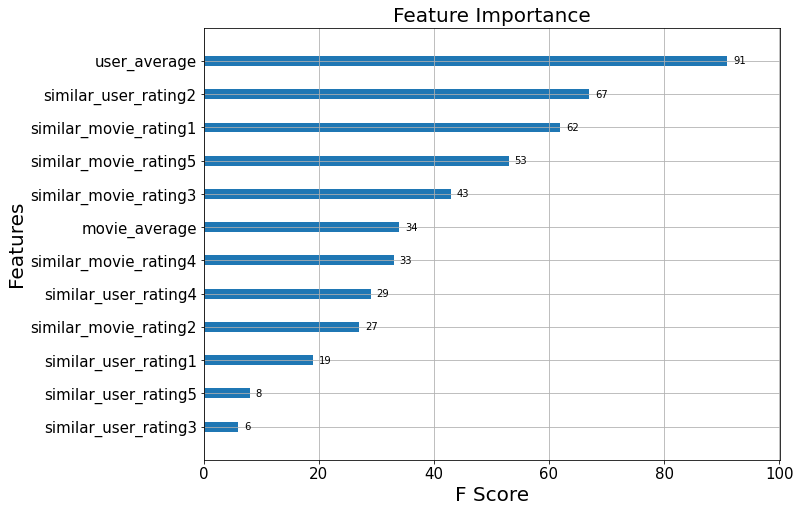

In [73]:
 plot_importance(xgb, clf)